In [2]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score

In [ ]:
## 파일 생성 및 경로
import os
from datetime import datetime

def file_make(filename):
    now = datetime.now()
    date =  now.strftime('%Y-%m-%d')

    file_path = './'+ filename +'/' + date
    os.makedirs(file_path,exist_ok=True)
    print(file_path)
    return file_path

In [20]:
import pandas as pd

trn_data = pd.read_csv('./data/2022-12-13/trn_data.csv')
tst_data = pd.read_csv('./data/2022-12-13/tst_data.csv')
sub = pd.read_csv('./data/sample_submission.csv')

In [4]:
trn_data.groupby('class').sum()

C:\Users\deepBlue\AppData\Local\Temp\ipykernel_16720\4217489923.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trn_data.groupby('class').sum()


,SNP_01_Enc,SNP_02_Enc,SNP_03_Enc,SNP_04_Enc,SNP_05_Enc,SNP_06_Enc,SNP_07_Enc,SNP_08_Enc,SNP_09_Enc,SNP_10_Enc,SNP_11_Enc,SNP_12_Enc,SNP_13_Enc,SNP_14_Enc,SNP_15_Enc,trait_1,trait_2
class,,,,,,,,,,,,,,,,,
A,27,132,0,103,14,118,120,11,79,40,125,116,135,79,109,69,0
B,203,132,121,79,179,101,9,171,24,224,103,40,89,0,46,0,114
C,123,49,67,9,57,61,21,72,1,106,34,23,101,21,55,0,79


In [5]:
def cat_to_num(df):
    df['class'] = df['class'].replace({'A':0,'B':1,'C':2})
    return df

In [6]:
def num_to_cat(df):
    df['class'] = df['class'].replace({0:'A',1:'B',2:'C'})
    return df

In [7]:
trn_data = cat_to_num(trn_data)

In [8]:
features = trn_data.drop(['id', 'class',],axis=1)
labels = trn_data['class']
X_train, X_test, y_train, y_test=train_test_split(features,labels,test_size=0.3,random_state=42)

In [9]:
# features.info()

In [10]:
import numpy as np
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    data, target = features,labels
    train_x, valid_x, train_y, valid_y = train_test_split(features,labels, test_size=0.3)

    param = {
        # 'loss_function':'MultiClass',
        "objective": trial.suggest_categorical("objective", ["MultiClass"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),        
        "depth": trial.suggest_int("depth", 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### caution
- max depth를 12 이상으로 주지 않는 것이 좋은 이유
The default tree growing strategy in catboost is symmetric trees. If you set depth to 16, then every tree will have 2^16 leaves, which is probably not what you want. It is recommended to use depth up to 10 or 12.

    - [catboost pararmeter training](https://catboost.ai/en/docs/concepts/parameter-tuning)

###
1. 캐글 코드 참고
    - https://www.kaggle.com/code/georgyzubkov/spaceship-eda-catboost-with-optuna
2. 설명 블로그 참고
    - https://ssoonidev.tistory.com/107
3. catboost 주요 개념
    - https://dailyheumsi.tistory.com/136

In [11]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-13 22:53:39,068] A new study created in memory with name: no-name-e808521a-5fb9-4baa-aae3-61168e5a7d1f
[I 2022-12-13 22:53:39,519] Trial 0 finished with value: 0.9620253164556962 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.06123743878821537, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8888087426397048}. Best is trial 0 with value: 0.9620253164556962.
[I 2022-12-13 22:53:39,879] Trial 1 finished with value: 0.9367088607594937 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.01564492604759704, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9620253164556962.
[I 2022-12-13 22:53:40,253] Trial 2 finished with value: 0.9367088607594937 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.0608935594132393, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.535412064058225}. Best is trial 0 with va

Number of finished trials: 100
Best trial:
  Value: 1.0
  Params: 
    objective: MultiClass
    colsample_bylevel: 0.010928558058250618
    depth: 10
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.24229089998368214


In [12]:
from optuna import visualization
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
hist = study.trials_dataframe()
hist.head()

Best trial: score 1.0,
params {'objective': 'MultiClass', 'colsample_bylevel': 0.010928558058250618, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24229089998368214}


,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_colsample_bylevel,params_depth,params_objective,params_subsample,state
0,0,0.962025,2022-12-13 22:53:39.069704,2022-12-13 22:53:39.519914,0 days 00:00:00.450210,NaN,Plain,Bernoulli,0.061237,9,MultiClass,0.888809,COMPLETE
1,1,0.936709,2022-12-13 22:53:39.519914,2022-12-13 22:53:39.879436,0 days 00:00:00.359522,NaN,Ordered,MVS,0.015645,8,MultiClass,NaN,COMPLETE
2,2,0.936709,2022-12-13 22:53:39.880454,2022-12-13 22:53:40.253084,0 days 00:00:00.372630,9.535412,Ordered,Bayesian,0.060894,5,MultiClass,NaN,COMPLETE
3,3,0.974684,2022-12-13 22:53:40.254086,2022-12-13 22:53:40.850519,0 days 00:00:00.596433,NaN,Ordered,MVS,0.090431,11,MultiClass,NaN,COMPLETE
4,4,0.974684,2022-12-13 22:53:40.851542,2022-12-13 22:53:41.081189,0 days 00:00:00.229647,NaN,Plain,Bernoulli,0.041925,12,MultiClass,0.649623,COMPLETE


In [14]:
# optuna.visualization.plot_slice(study)

In [15]:
# optuna.visualization.plot_optimization_history(study)

In [16]:
# optuna.visualization.plot_param_importances(study)

In [17]:
# y_train = y_train.replace({False:0,True:1})

In [13]:
# 그리드서치로 재훈련
# 'objective': 'MultiClass', 'colsample_bylevel': 0.010928558058250618, 'depth': 10, 
# 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24229089998368214
clf=CatBoostClassifier()
parametres={'objective': ['MultiClass'], 'colsample_bylevel': [0.010928558058250618], 
'depth': [10],'boosting_type': ['Ordered'], 'bootstrap_type': ['Bernoulli'], 'subsample': [0.24229089998368214],}
grid_search_cv_clf=GridSearchCV(clf,parametres,cv=5)
grid_search_cv_clf.fit(X_train,y_train)
best_clf2=grid_search_cv_clf.best_estimator_
y_pred2=best_clf2.predict(X_test)
print(f'Accuracy_score: {accuracy_score(y_test,y_pred2)}')

Learning rate set to 0.071731
0:	learn: 1.0939761	total: 387us	remaining: 387ms
1:	learn: 1.0899955	total: 777us	remaining: 388ms
2:	learn: 1.0865728	total: 1.11ms	remaining: 370ms
3:	learn: 1.0836261	total: 1.38ms	remaining: 343ms
4:	learn: 1.0810863	total: 1.64ms	remaining: 326ms
5:	learn: 1.0247524	total: 1.93ms	remaining: 319ms
6:	learn: 1.0228789	total: 2.15ms	remaining: 305ms
7:	learn: 1.0212600	total: 2.41ms	remaining: 299ms
8:	learn: 1.0198604	total: 2.65ms	remaining: 292ms
9:	learn: 1.0048109	total: 2.96ms	remaining: 293ms
10:	learn: 1.0037687	total: 3.19ms	remaining: 287ms
11:	learn: 1.0028663	total: 3.41ms	remaining: 281ms
12:	learn: 1.0020847	total: 3.62ms	remaining: 275ms
13:	learn: 0.9835310	total: 3.86ms	remaining: 272ms
14:	learn: 0.9829551	total: 4.07ms	remaining: 267ms
15:	learn: 0.9824558	total: 4.28ms	remaining: 263ms
16:	learn: 0.9820229	total: 4.47ms	remaining: 259ms
17:	learn: 0.9816474	total: 4.71ms	remaining: 257ms
18:	learn: 0.9813217	total: 4.93ms	remaining: 

In [14]:
# 모델 저장
import joblib
model_path = file_make('model') + '/CATboost' +'.model'
best_clf2.save_model(model_path)
joblib.dump(best_clf2, open(model_path, 'wb'))

./model/2022-12-13


Text(0.5, 1.0, 'Feature Importance')

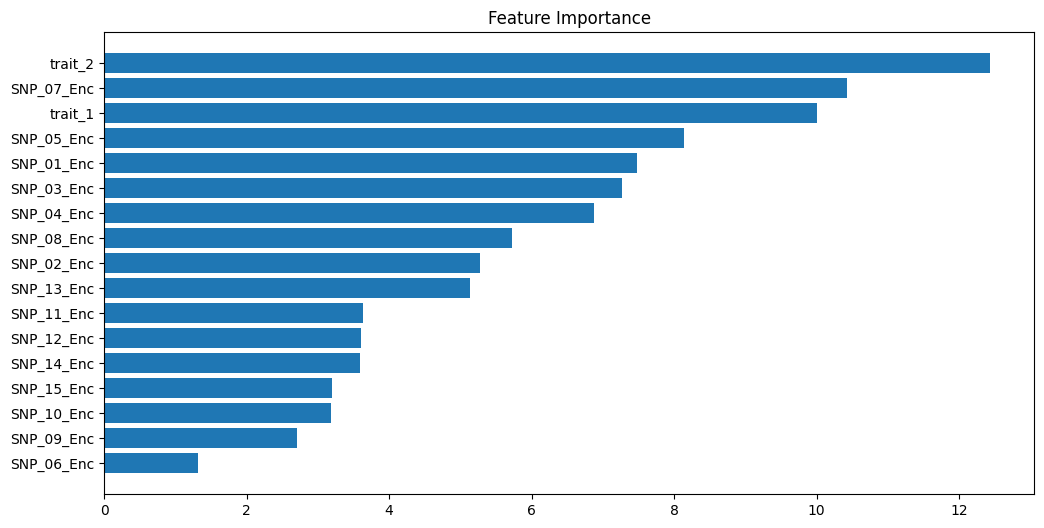

In [15]:
import matplotlib.pyplot as plt

feature_importance = best_clf2.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


In [17]:
tst_data.columns

Index(['id', 'SNP_01_Enc', 'SNP_02_Enc', 'SNP_03_Enc', 'SNP_04_Enc',
       'SNP_05_Enc', 'SNP_06_Enc', 'SNP_07_Enc', 'SNP_08_Enc', 'SNP_09_Enc',
       'SNP_10_Enc', 'SNP_11_Enc', 'SNP_12_Enc', 'SNP_13_Enc', 'SNP_14_Enc',
       'SNP_15_Enc', 'trait_1', 'trait_2'],
      dtype='object')

In [24]:
test01 = tst_data.drop(['id', ],axis=1)
y_predicted=best_clf2.predict(test01)
tst_data['class'] = y_predicted

In [35]:
sub = pd.read_csv('./data/sample_submission.csv')
sub = sub.drop(['class'],axis=1)
submit = pd.merge(sub, tst_data[['id','class']], how='outer', on = 'id')
submit = num_to_cat(submit)

In [41]:
submit_path = file_make('submit_file') +'/submitionCat.csv'
submit.to_csv(submit_path,index=False)

./submit_file/2022-12-13


In [42]:
submit_check = pd.read_csv(submit_path)
submit_check

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,B
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B
